In [128]:
import os
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from aeon.datasets import load_classification
from TSTTrainer import TimeSeriesTransformer  # or import the model from the shared module



In [129]:
def get_transformer_input(model, instance):
    """Processes a single instance (shape: (seq_len, input_dim)) through conv layers and adds positional encoding."""
    x = instance.unsqueeze(0)  # (1, seq_len, input_dim)
    x = x.transpose(1, 2)  # (1, input_dim, seq_len)
    x = torch.relu(model.bn1(model.conv1(x)))
    x = torch.relu(model.bn2(model.conv2(x)))
    x = torch.relu(model.bn3(model.conv3(x)))
    x = x.transpose(1, 2)  # (1, seq_len, d_model)
    x = x + model.positional_encoding
    return x


In [130]:
def run_denoising_patching(model, clean_instance, corrupted_instance, patch_layer_idx):
    """
    Runs the transformer encoder on clean and corrupted inputs,
    then patches the corrupted activation with the clean one at the given layer.
    Returns the output logits.
    """
    x_clean = get_transformer_input(model, clean_instance)
    x_corr = get_transformer_input(model, corrupted_instance)

    # Obtain clean activation at the chosen patch layer.
    x_clean_current = x_clean.clone()
    for i, layer in enumerate(model.transformer_encoder.layers):
        if i == patch_layer_idx:
            patch_activation = x_clean_current.clone()
        x_clean_current = layer(x_clean_current)

    # Run corrupted input and replace activation at patch layer.
    x_corr_current = x_corr.clone()
    for i, layer in enumerate(model.transformer_encoder.layers):
        if i == patch_layer_idx:
            x_corr_current = patch_activation.clone()
        else:
            x_corr_current = layer(x_corr_current)

    pooled = model.pool(x_corr_current.transpose(1, 2)).squeeze(-1)
    logits = model.classifier(pooled)
    return logits

In [131]:
# Load test dataset
X_train, y_train = load_classification("JapaneseVowels", split="train")
X_test, y_test = load_classification("JapaneseVowels", split="test")

# Convert labels to integers.
y_train = np.array(y_train).astype(np.int64)
y_test = np.array(y_test).astype(np.int64)

# Process X_test: swap axes as needed.
X_test_np = np.swapaxes(X_test.astype(np.float32), 1, 2)
min_val = y_train.min()
if min_val != 0:
    y_test = y_test - min_val
X_test_tensor = torch.tensor(X_test_np)
y_test_tensor = torch.tensor(y_test)

batch_size = 4
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seq_len = X_test_tensor.shape[1]
input_dim = X_test_tensor.shape[2]
num_classes = len(np.unique(y_test))

In [132]:
# Load the saved model.
model = TimeSeriesTransformer(input_dim, num_classes, seq_len, d_model=128, nhead=8,
                              num_layers=3, dim_feedforward=256, dropout=0.1).to(device)
model_path = "time_series_transformer_fancy.pth"
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    print("Loaded saved model from", model_path)
else:
    print("Model file not found. Run training first.")



Loaded saved model from time_series_transformer_fancy.pth


C:\Users\gebruiker\AppData\Local\Temp\ipykernel_13508\2672683762.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_locatio

In [133]:
# Run inference on test set and collect predictions.
results = []
with torch.no_grad():
    global_index = 0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        logits = model(X_batch)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)
        for i in range(X_batch.size(0)):
            results.append({
                "index": global_index,
                "true_label": y_batch[i].item(),
                "pred_label": preds[i].item(),
                "confidence": probs[i].max().item()
            })
            global_index += 1

print("Total test instances processed:", len(results))

Total test instances processed: 370


In [134]:
# Save results as CSV
df = pd.DataFrame(results)
df.to_csv("test_results.csv", index=False)
print("Test predictions saved to 'test_results.csv'.")


Test predictions saved to 'test_results.csv'.


In [135]:
# Convert results list to a dictionary keyed by index for fast lookup.
def convert_list_to_dict(chosen_correct_index, chosen_incorrect_index):
    results_dict = {r["index"]: r for r in results}
    if chosen_correct_index not in results_dict or chosen_incorrect_index not in results_dict:
        print("Chosen indices not found in the results. Please check test_results.csv.")

    return results_dict

In [136]:

def load_test_instances(chosen_correct_index, chosen_incorrect_index):

    correct_instance = X_test_tensor[chosen_correct_index]
    incorrect_instance = X_test_tensor[chosen_incorrect_index]
    print("Selected correct instance index:", chosen_correct_index,
        "and incorrect instance index:", chosen_incorrect_index)

    return correct_instance, incorrect_instance

In [137]:
# --- Manual selection ---
# After reviewing test_results.csv, set these indices to the desired instances.
# For example:
chosen_correct_index = 0  # change this to the index you want (a correct instance)
chosen_incorrect_index = 1  # change this to the index you want (a misclassified instance)
correct_instance, incorrect_instance = load_test_instances(chosen_correct_index, chosen_incorrect_index)

# Choose a transformer encoder layer index to patch.
patch_layer_index = 1  # adjust as desired

Selected correct instance index: 0 and incorrect instance index: 1


In [138]:
def summarize_diffs(model, clean_inst, corrupt_inst, device):
    """
    Returns
        attn_diff : (layers, heads)  mean |Δ attention| per head
        mlp_diff  : (layers,)        mean |Δ MLP output|
    """
    model.eval()
    n_layers = len(model.transformer_encoder.layers)
    n_heads  = model.transformer_encoder.layers[0].self_attn.num_heads

    # helper – run trunk conv‑BN once
    def trunk(x):
        x = x.transpose(1, 2)
        x = torch.relu(model.bn1(model.conv1(x)))
        x = torch.relu(model.bn2(model.conv2(x)))
        x = torch.relu(model.bn3(model.conv3(x)))
        x = x.transpose(1, 2)
        return x + model.positional_encoding

    # run both instances and collect summaries layer‑by‑layer
    summaries = { "clean_attn": [], "corr_attn": [],
                  "clean_mlp":  [], "corr_mlp":  [] }

    for label, inst in [("clean", clean_inst), ("corr", corrupt_inst)]:
        x = trunk(inst.to(device).unsqueeze(0))        # (1, L, d_model)

        for lyr in model.transformer_encoder.layers:
            # ensure we get per‑head matrices
            lyr.self_attn.average_attn_weights = False

            # --- attention ---
            attn_out, attn_w = lyr.self_attn(
                x, x, x, need_weights=True, average_attn_weights=False
            )                                           # (1, heads, L, L)
            head_vec = attn_w.mean(dim=(-1, -2)).squeeze(0)   # (heads,)
            summaries[f"{label}_attn"].append(head_vec)       # keep on GPU

            # residual & norm
            x = x + lyr.dropout1(attn_out)
            x = lyr.norm1(x)

            # --- MLP ---
            ff = lyr.linear2(lyr.dropout(lyr.activation(lyr.linear1(x))))  # (1,L,d)
            mlp_scalar = ff.abs().mean()                                   # scalar
            summaries[f"{label}_mlp"].append(mlp_scalar)

            # residual & norm
            x = x + lyr.dropout2(ff)
            x = lyr.norm2(x)

    # compute absolute differences
    attn_diff = torch.stack([
        torch.abs(a - b)                     # (heads,)
        for a, b in zip(summaries["clean_attn"], summaries["corr_attn"])
    ])                                        # (layers, heads)

    mlp_diff = torch.stack([
        torch.abs(a - b)
        for a, b in zip(summaries["clean_mlp"], summaries["corr_mlp"])
    ])                                         # (layers,)

    return attn_diff.cpu(), mlp_diff.cpu()

In [139]:
def plot_diffs(attn_diff, mlp_diff):
    layers, heads = attn_diff.shape
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(1.2*heads + 4, 2 + 0.7*layers), gridspec_kw=dict(hspace=0.4)
    )

    # ---- attention heat‑map ----
    sns.heatmap(
        attn_diff.detach().numpy(),
        ax=ax1, cmap="rocket_r",
        xticklabels=[f"H{h}" for h in range(heads)],
        yticklabels=[f"L{l}" for l in range(layers)],
        cbar_kws=dict(label="mean |Δ attention|")
    )
    ax1.set_title("Per‑head attention difference  (clean vs corrupt)")
    ax1.set_xlabel("Head");  ax1.set_ylabel("Layer")

    # ---- MLP bar chart ----
    ax2.bar(np.arange(layers), mlp_diff.detach().numpy())
    ax2.set_xticks(np.arange(layers)); ax2.set_xlabel("Layer")
    ax2.set_ylabel("mean |Δ MLP output|")
    ax2.set_title("Per‑layer MLP difference")

    plt.tight_layout()
    plt.show()

In [175]:
# --- Manual selection ---
# After reviewing test_results.csv, set these indices to the desired instances.
# For example:
chosen_correct_index = 0 # change this to the index you want (a correct instance)
chosen_incorrect_index = 26  # change this to the index you want (a misclassified instance)
correct_instance, incorrect_instance = load_test_instances(chosen_correct_index, chosen_incorrect_index)


Selected correct instance index: 0 and incorrect instance index: 26


C:\Users\gebruiker\AppData\Local\Temp\ipykernel_13508\80319436.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


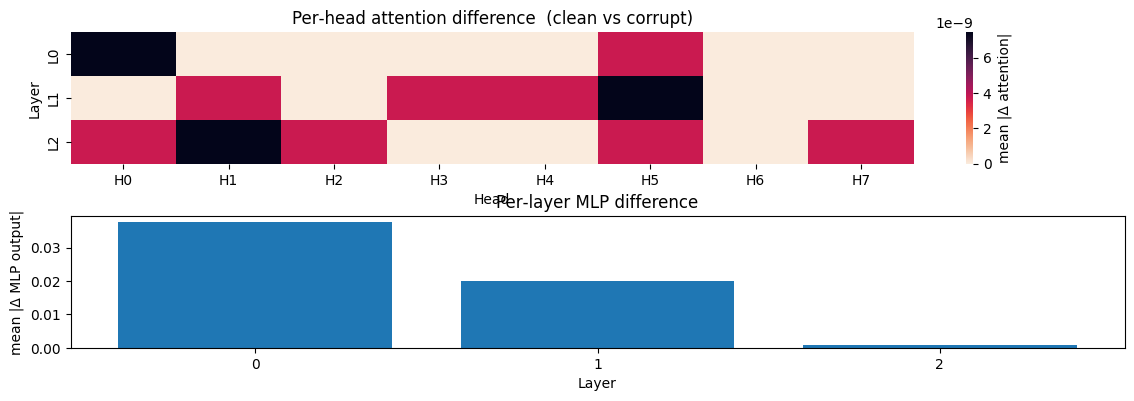

In [176]:
%matplotlib inline
attn_diff, mlp_diff = summarize_diffs(model, correct_instance, incorrect_instance, device)
plot_diffs(attn_diff, mlp_diff)

In [161]:

patch_layer_index = 1

In [181]:

with torch.no_grad():
    # Run the model normally for the selected instances.
    correct_logits = model(correct_instance.unsqueeze(0))
    correct_probs = F.softmax(correct_logits, dim=1)
    incorrect_logits = model(incorrect_instance.unsqueeze(0))
    incorrect_probs = F.softmax(incorrect_logits, dim=1)

    # Run the denoising patch experiment: patching the incorrect instance using the correct activation.
    patched_logits = run_denoising_patching(model, correct_instance.to(device),
                                            incorrect_instance.to(device),
                                            patch_layer_index)
    patched_probs = F.softmax(patched_logits, dim=1)

In [182]:
# Save outputs for later plotting.
np.savez("patching_results.npz",
         clean_logits=correct_logits.cpu().numpy().flatten(),
         corrupted_logits=incorrect_logits.cpu().numpy().flatten(),
         patched_logits=patched_logits.cpu().numpy().flatten(),
         clean_probs=correct_probs.cpu().numpy().flatten(),
         corrupted_probs=incorrect_probs.cpu().numpy().flatten(),
         patched_probs=patched_probs.cpu().numpy().flatten(),
         num_classes=num_classes)

print("Patching experiment completed and results saved to 'patching_results.npz'.")

Patching experiment completed and results saved to 'patching_results.npz'.


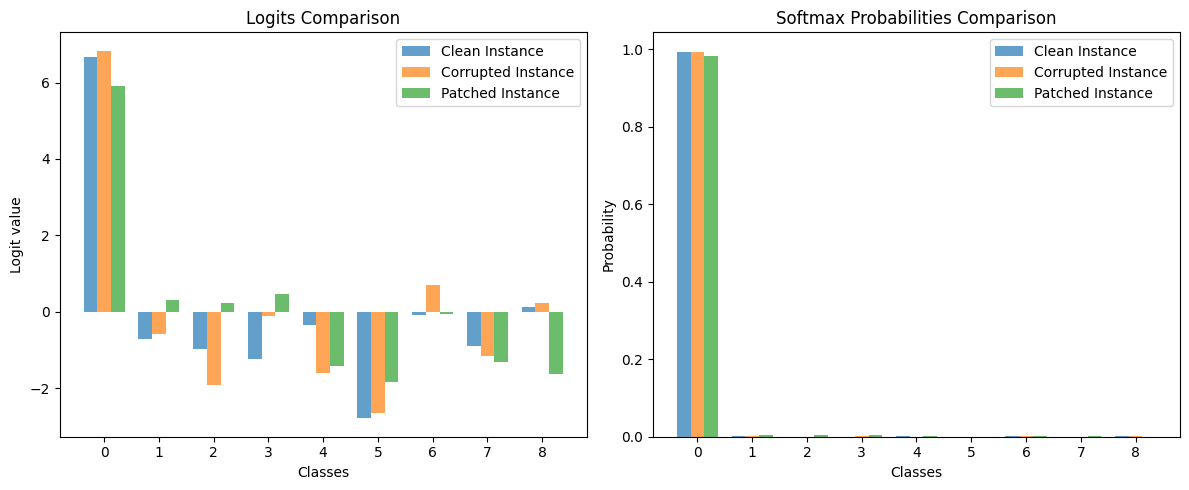

In [184]:

# Load the saved results.
data = np.load("patching_results.npz")
corrupted_logits = data["corrupted_logits"]
clean_logits = data["clean_logits"]
patched_logits = data["patched_logits"]
corrupted_probs = data["corrupted_probs"]
clean_probs = data["clean_probs"]
patched_probs = data["patched_probs"]
num_classes = int(data["num_classes"])
classes = list(range(num_classes))

width = 0.25
x = np.arange(num_classes)

# Plot logits.
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(x - width, clean_logits, width=width, label='Clean Instance', alpha=0.7)
plt.bar(x, corrupted_logits, width=width, label='Corrupted Instance', alpha=0.7)
plt.bar(x + width, patched_logits, width=width, label='Patched Instance', alpha=0.7)
plt.xlabel("Classes")
plt.ylabel("Logit value")
plt.title("Logits Comparison")
plt.xticks(x, classes)
plt.legend()

# Plot probabilities.
plt.subplot(1, 2, 2)
plt.bar(x - width, clean_probs, width=width, label='Clean Instance', alpha=0.7)
plt.bar(x, corrupted_probs, width=width, label='Corrupted Instance', alpha=0.7)
plt.bar(x + width, patched_probs, width=width, label='Patched Instance', alpha=0.7)
plt.xlabel("Classes")
plt.ylabel("Probability")
plt.title("Softmax Probabilities Comparison")
plt.xticks(x, classes)
plt.legend()

plt.tight_layout()
plt.show()